## ***Sentiment Analysis Project using BERT Model***

In [1]:
import torch
import warnings
warnings.filterwarnings("ignore")

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [2]:
# load BERT model

from transformers import BertModel

# download bert pretrained model

bert = BertModel.from_pretrained('bert-base-uncased') # this model was trained on lowercase text data

In [3]:
print(bert)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [4]:
# download Bert tokenizer

from transformers import BertTokenizerFast

# load Bert tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased',do_lower_case = True)

In [5]:
# input text

text = "Jim Henson was a puppeteer"

sent_id = tokenizer.encode(text,
                        # add [CLS] and [SEP] tokens
                        add_special_tokens = True,
                        # specify maximum length 
                        max_length = 10,
                        truncation = True,
                        # add pad token to the right side of the token
                        padding = 'max_length')

# print integer sequence
print(f"Integer Sequence {sent_id}")

# 101 is [CLS] token in integer
# 102 is [SEP] token in integer
# last two 0's are the result of padding to make it max_length 10

Integer Sequence [101, 3958, 27227, 2001, 1037, 13997, 11510, 102, 0, 0]


In [6]:
# converting integer back to text as we can see 6 tokens generated for 5 words

print("Tokenized Text:",tokenizer.convert_ids_to_tokens(sent_id))

Tokenized Text: ['[CLS]', 'jim', 'henson', 'was', 'a', 'puppet', '##eer', '[SEP]', '[PAD]', '[PAD]']


In [7]:
# decode the tokenized text

decode = tokenizer.decode(sent_id)
print("Decode String {}".format(decode))

Decode String [CLS] jim henson was a puppeteer [SEP] [PAD] [PAD]


In [8]:
# mask to avoid performing attention on padding tokens
# mask values : 1 is for that tokens that are NOT MASKED, 0 for MASKED tokens.

att_mask = [int(tok > 0)for tok in sent_id]
print("Attention Mask",att_mask)

Attention Mask [1, 1, 1, 1, 1, 1, 1, 1, 0, 0]


***Understanding Input and Output***

In [9]:
# convert list to tensors

sent_id = torch.tensor(sent_id)
att_mask = torch.tensor(att_mask)

# reshaping tensor in the form of (batch,text length)

sent_id = sent_id.unsqueeze(0)
att_mask = att_mask.unsqueeze(0)

# printing reshaped tensor
print(sent_id)

tensor([[  101,  3958, 27227,  2001,  1037, 13997, 11510,   102,     0,     0]])


In [10]:
# pass integer sequence to the Bert Model

outputs = bert(sent_id,att_mask)

In [11]:
# unpack the output of Bert model

all_hidden_states = outputs[0]

cls_hidden_state = outputs[1]

print("Shapre of last hidden states:",all_hidden_states.shape)

print("Shapre of CLS hidden states:",cls_hidden_state.shape)

Shapre of last hidden states: torch.Size([1, 10, 768])
Shapre of CLS hidden states: torch.Size([1, 768])


In [12]:
cls_hidden_state

tensor([[-0.8767, -0.4109, -0.1220,  0.4494,  0.1945, -0.2698,  0.8316,  0.3127,
          0.1178, -1.0000, -0.1561,  0.6677,  0.9891, -0.3451,  0.8812, -0.6753,
         -0.3079, -0.5580,  0.4380, -0.4588,  0.5831,  0.9956,  0.4467,  0.2863,
          0.3924,  0.6864, -0.7513,  0.9043,  0.9436,  0.8207, -0.6493,  0.3524,
         -0.9919, -0.2295, -0.0742, -0.9936,  0.3698, -0.7558,  0.0792, -0.2218,
         -0.8637,  0.4711,  0.9997, -0.4368,  0.0404, -0.3498, -1.0000,  0.2663,
         -0.8711,  0.0508,  0.0505, -0.1634,  0.1716,  0.4363,  0.4330, -0.0333,
         -0.0416,  0.2206, -0.2568, -0.6122, -0.5916,  0.2569, -0.2622, -0.9041,
          0.3221, -0.2394, -0.2634, -0.3454, -0.0723,  0.0081,  0.8297,  0.2279,
          0.1614, -0.6555, -0.2062,  0.3280, -0.4016,  1.0000, -0.0952, -0.9874,
         -0.0400,  0.0717,  0.3675,  0.3373, -0.3710, -1.0000,  0.4479, -0.1722,
         -0.9917,  0.2677,  0.4844, -0.2207, -0.3207,  0.3715, -0.2171, -0.2522,
         -0.3071, -0.3161, -

## ***Data Preparation***

In [13]:
# import tweet.csv

import pandas as pd
pd.set_option('display.max_colwidth',200)

# read csv file

tweets = pd.read_csv(r"/Users/nick_mac/Desktop/Natural-Language-Processing/BERT-Project/data/Tweets.csv")

# print top 5 rows

tweets.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [14]:
# lets check the dataframe

tweets.shape

(14640, 15)

In [15]:
# randomly sample of tweets

tweets['text'].sample(5)

5156                                                                                      @SouthwestAir I'll do that. Can't DM until you follow me. Thanks!
13091                                  @AmericanAir don't they already know ?  Isn't everyone sharing how nasty the food is? It's not even close to decent.
10873    @USAirways Cancelled Flightled flight, 50 person line and one agent helping to rebook. You could've handed this one better. http://t.co/By3vDioSUA
6346                              @SouthwestAir CEO discusses possibilities of NHL Vegas arena naming rights http://t.co/t3E4SH5xNg @SMUSportMgt #sportsbiz
13814                                                                                                                            @AmericanAir ticks me off.
Name: text, dtype: object

In [16]:
# sentiment class distribution

tweets['airline_sentiment'].value_counts()

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

In [17]:
# let's check the proportion

tweets['airline_sentiment'].value_counts(normalize=True)

airline_sentiment
negative    0.626913
neutral     0.211680
positive    0.161407
Name: proportion, dtype: float64

In [18]:
# saving the value counts to a list

class_count = tweets['airline_sentiment'].value_counts().to_list()
class_count

[9178, 3099, 2363]

## ***Text Cleaning***

In [19]:
import re

def preprocessor(text):
    text = text.lower()
    text = re.sub(r'@[A-Za-z0-9]+','',text)
    text = re.sub(r'http\S+','',text)
    tokens = text.split()
    return " ".join(tokens)

In [20]:
# perform text cleaning

tweets['clean_text'] = tweets['text'].apply(preprocessor)

In [21]:
# save cleaned text and labels to the variable

text = tweets['clean_text'].values
labels = tweets['airline_sentiment'].values

In [22]:
# cleaned text

text[1:10]

array(["plus you've added commercials to the experience... tacky.",
       "i didn't today... must mean i need to take another trip!",
       'it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse',
       "and it's a really big bad thing about it",
       "seriously would pay $30 a flight for seats that didn't have this playing. it's really the only bad thing about flying va",
       'yes, nearly every time i fly vx this “ear worm” won’t go away :)',
       'really missed a prime opportunity for men without hats parody, there.',
       "well, i didn't…but now i do! :-d",
       "it was amazing, and arrived an hour early. you're too good to me."],
      dtype=object)

### ***Preparing Input and Output Data***

In [23]:
# importing label encode

from sklearn.preprocessing import LabelEncoder

# define label encoder
le = LabelEncoder()

# fit and transform
labels = le.fit_transform(labels)

In [24]:
# classes

print(le.classes_)
print(labels)

['negative' 'neutral' 'positive']
[1 2 1 ... 1 0 1]


Text(0.5, 1.0, 'Length of sentences')

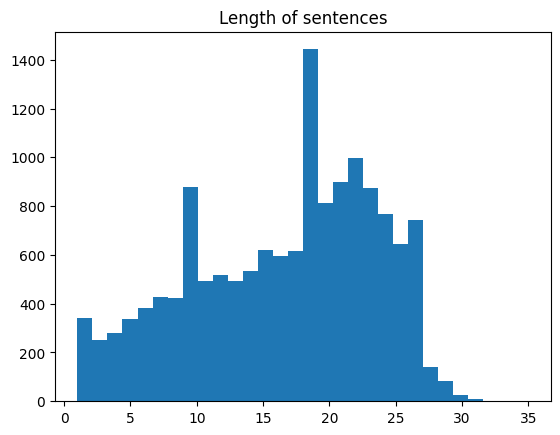

In [25]:
# printing the sequence of the tweets

import matplotlib.pyplot as plt

num = [len(i.split()) for i in text]

plt.hist(num,bins= 30)

plt.title("Length of sentences")

# the most of the tweets hasmax length of 30

In [26]:
# define maximum length of a text

max_len = 25

In [27]:
# library for progress bar

from tqdm import tqdm

# create an empty list to save integer sequence

sent_id = []

# iterate over each tweet

for i in tqdm(range(len(text))):
    encoded_sent = tokenizer.encode(text[i],
                                    add_special_tokens = True,
                                    max_length = max_len,
                                    truncation = True,
                                    padding = 'max_length')
    
    sent_id.append(encoded_sent)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 14640/14640 [00:00<00:00, 18802.73it/s]


In [28]:
print ("Integer Sequence",sent_id[0])

Integer Sequence [101, 2054, 2056, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [29]:
# create attention masks
attention_masks = []

for sent in sent_id:
    att_mask = [int(token_id) > 0 for token_id in sent]

    attention_masks.append(att_mask)

### ***Training and Validation Dataset***

In [30]:
from sklearn.model_selection import train_test_split

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(sent_id,labels, random_state= 2018,test_size= 0.1,stratify=labels)

train_masks, validation_masks, _,_ = train_test_split(attention_masks,labels,random_state= 2018,test_size= 0.1,stratify=labels)

### ***Define Data loader***

In [31]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [32]:
from torch.utils.data import TensorDataset,DataLoader,RandomSampler,SequentialSampler

# define batch size
batch_size = 32

# Dataset wrapping tensors
train_data = TensorDataset(train_inputs,train_masks,train_labels)

train_sampler = RandomSampler(train_data)

train_dataloader = DataLoader(train_data,sampler = train_sampler,batch_size=batch_size)

validation_data = TensorDataset(validation_inputs,validation_masks,validation_labels)

validation_sampler = SequentialSampler(validation_data)

validation_dataloader = DataLoader(validation_data,sampler = validation_sampler,batch_size=batch_size)

In [33]:
# create an iterator object
iterator = iter(train_dataloader)

# loads batch data
sent_id, mask, target = next(iterator)

In [36]:
sent_id.shape

torch.Size([32, 25])

In [38]:
# pass inputs to the model
outputs = bert(sent_id,attention_mask=mask)

In [39]:
# hidden states
hidden_states = outputs[0]

# [CLS] hidden state
CLS_hidden_state = outputs[1]

print(hidden_states.shape)
print(CLS_hidden_state.shape)

torch.Size([32, 25, 768])
torch.Size([32, 768])


## ***Model Finetuning***

Steps to follow while finetuning Head only:

1. Turn off Gradient, means freeze the Bert parameters
2. Define Model Architecture
3. Define Optimizer and Loss function
4. Define Traine and Validations set
5. Train the model
6. Evaluate the model

***1.Turn Off Gradient***

In [40]:
for param in bert.parameters():
    param.requires_grad = False

***2.Define Model Architecture***

In [49]:
import torch.nn as nn

class classifier(nn.Module):

    def __init__(self,bert):

        super(classifier,self).__init__()

        self.bert = bert

        # dense layer 1
        self.fc1 = nn.Linear(768,512)

        # dense layer 2
        self.fc2 = nn.Linear(512,3)

        #dropout layer (output layer)
        self.dropout= nn.Dropout(0.1)

        # Activation Function
        self.relu = nn.ReLU()

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
        # pass the input to the model
        outputs = self.bert(input_ids=sent_id, attention_mask=mask)

        # use pooler_output as the [CLS] token representation
        cls_hidden_state = outputs.pooler_output

        # pass CLS hidden state to the dense layer
        x = self.fc1(cls_hidden_state)

        # Apply ReLU activation function
        x = self.relu(x)

        # Apply dropout
        x = self.dropout(x)

        # pass input to the output layer
        x = self.fc2(x)

        # apply softmax
        x = self.softmax(x)

        return x

In [50]:
# create the model
model = classifier(bert)

model = model.to(device)

In [51]:
# model architecture
model

classifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [52]:
sent_id = sent_id.to(device)
mask = mask.to(device)
target = target.to(device)

outputs = model(sent_id,mask)

In [53]:
print(outputs)

tensor([[-1.1624, -1.1286, -1.0112],
        [-1.2495, -1.0671, -0.9960],
        [-1.1694, -1.0446, -1.0858],
        [-1.2061, -1.0349, -1.0631],
        [-1.1935, -0.9883, -1.1251],
        [-1.1154, -1.0898, -1.0909],
        [-1.2971, -1.0167, -1.0082],
        [-1.2236, -1.0502, -1.0329],
        [-1.2516, -0.9879, -1.0741],
        [-1.2046, -1.0808, -1.0192],
        [-1.1865, -1.0489, -1.0660],
        [-1.1057, -1.1272, -1.0640],
        [-1.2885, -1.0379, -0.9939],
        [-1.1669, -1.0772, -1.0552],
        [-1.2341, -1.0049, -1.0705],
        [-1.2064, -1.0982, -1.0017],
        [-1.0878, -1.1586, -1.0524],
        [-1.1506, -1.1345, -1.0162],
        [-1.3030, -1.0295, -0.9914],
        [-1.1649, -1.0362, -1.0989],
        [-1.2232, -1.0523, -1.0312],
        [-1.1489, -1.1104, -1.0396],
        [-1.2412, -1.0431, -1.0255],
        [-1.2425, -0.9975, -1.0714],
        [-1.1862, -1.1507, -0.9724],
        [-1.2368, -1.0406, -1.0316],
        [-1.1939, -1.0280, -1.0811],
 

In [54]:
# to get the number of trainable parameter

def count_parameter(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'the model has {count_parameter(model):,} trainable parameters')

the model has 395,267 trainable parameters


***3.Define optimizer and Loss function***

In [55]:
# adam optimizer

optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

Text(0.5, 1.0, 'class Distributions')

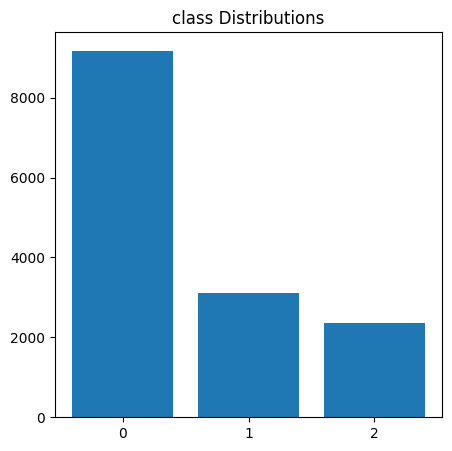

In [56]:
# understand the class distribution
keys = ['0','1','2']

plt.figure(figsize=(5,5))

plt.bar(keys,class_count)

plt.title('class Distributions')

In [58]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)

print('class weight:', class_weights)

class weight: [0.53170625 1.57470152 2.06517139]


In [59]:
weights = torch.tensor(class_weights,dtype=torch.float)

weights = weights.to(device)

cross_entropy = nn.NLLLoss(weight = weights)

In [60]:
# compute loss 

loss = cross_entropy(outputs,target)
print(loss)

tensor(1.0893, device='mps:0', grad_fn=<NllLossBackward0>)


In [61]:
import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

***4.Model Training and Evaluation***

In [62]:
def train():
    print("\ntraining.....")

    model.train()

    t0 = time.time()

    # initialize loss and accuracy to 0
    total_loss,total_accuracy = 0,0

    total_preds= []

    for step,batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)

            print(' Batch {:>5,} of {:>5,}. Elapsed: {:}'.format(step,len(train_dataloader),elapsed))

        batch = tuple(t.to(device) for t in batch)

        sent_id,mask,labels = batch

        model.zero_grad()

        pred = model(sent_id,mask)

        loss = cross_entropy(pred,labels)

        total_loss = total_loss + loss.item()

        loss.backward()

        optimizer.step()

        preds = preds.detach().cpu().numpy()

        total_preds.append(preds)

    avg_loss = total_loss/len(train_dataloader)

    total_preds = np.concatenate(total_preds,axis = 0)

    return avg_loss,total_preds


In [66]:
import time
import torch
import numpy as np
import torch.nn.functional as F

# Optional: helper to format elapsed time
def format_time(elapsed):
    return str(time.strftime("%H:%M:%S", time.gmtime(elapsed)))

# Define a function for evaluating the model
def evaluate():
    print("\nEvaluating.....")

    # Set the model to evaluation mode
    model.eval()

    t0 = time.time()

    total_loss = 0
    total_preds = []

    # For each batch in validation data
    for step, batch in enumerate(validation_dataloader):

        # Progress update
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(validation_dataloader), elapsed))

        # Move batch to GPU if available
        batch = tuple(t.to(device) for t in batch)
        sent_id, mask, labels = batch

        with torch.no_grad():
            # Get predictions
            outputs = model(sent_id, mask)

            # If model returns a tuple (like BERT), extract logits
            if isinstance(outputs, tuple):
                logits = outputs[0]
            else:
                logits = outputs

            # Calculate loss (you must define `loss_fn`)
            loss = loss_fn(logits, labels)
            total_loss += loss.item()

            # Move logits to CPU and convert to numpy
            preds = logits.detach().cpu().numpy()
            total_preds.append(preds)

    # Compute average loss
    avg_loss = total_loss / len(validation_dataloader)

    # Stack predictions
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [67]:
import torch

# Assign the initial loss to infinity
best_valid_loss = float('inf')

# Create empty lists to store training and validation loss of each epoch
train_losses = []
valid_losses = []

# Number of training epochs
epochs = 5

# For each epoch
for epoch in range(epochs):
    print('\n........... epoch {} / {} ..........'.format(epoch + 1, epochs))

    # Train the model
    train_loss, _ = train()

    # Evaluate the model
    valid_loss, _ = evaluate()

    # Save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # Accumulate training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # Print loss for current epoch
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

print("")
print("Training complete!")


........... epoch 1 / 5 ..........

training.....


UnboundLocalError: local variable 'preds' referenced before assignment